In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from nengo_bio.internal.qp_solver import solve as solve_ref

import os, sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from bioneuronqp import solve

In [2]:
class LIF:
    slope = 2.0 / 3.0

    @staticmethod
    def inverse(a):
        valid = a > 0
        return 1.0 / (1.0 - np.exp(LIF.slope - (1.0 / (valid * a + 1e-6))))

    @staticmethod
    def activity(x):
        valid = x > (1.0 + 1e-6)
        return valid / (LIF.slope - np.log(1.0 - valid * (1.0 / x)))

class Ensemble:
    def __init__(self, n_neurons, n_dimensions, neuron_type=LIF):
        self.neuron_type = neuron_type

        # Randomly select the intercepts and the maximum rates
        self.intercepts = np.random.uniform(-0.95, 0.95, n_neurons)
        self.max_rates = np.random.uniform(0.5, 1.0, n_neurons)

        # Randomly select the encoders
        self.encoders = np.random.normal(0, 1, (n_neurons, n_dimensions))
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, None]

        # Compute the current causing the maximum rate/the intercept
        J_0 = self.neuron_type.inverse(0)
        J_max_rates = self.neuron_type.inverse(self.max_rates)

        # Compute the gain and bias
        self.gain = (J_0 - J_max_rates) / (self.intercepts - 1.0)
        self.bias = J_max_rates - self.gain

    def __call__(self, x):
        return self.neuron_type.activity(self.J(x))

    def J(self, x):
        return self.gain[:, None] * self.encoders @ x + self.bias[:, None]

In [3]:
def compute_error(J_tar, J_dec, i_th):
    if i_th is None:
        e_invalid = 0
        e_valid = np.sum(np.square(J_tar - J_dec))
    else:
        valid = J_tar > i_th
        invalid_violated = np.logical_and(J_tar < i_th, J_dec > i_th)
        e_invalid = np.sum(np.square(i_th - J_dec[invalid_violated]))
        e_valid = np.sum(np.square(J_tar[valid] - J_dec[valid]))

    return np.sqrt((e_valid + e_invalid) / J_tar.size)

def E(Apre, Jpost, WE, WI, iTh):
    return compute_error(Jpost.T, Apre.T @ WE - Apre.T @ WI, iTh)

In [7]:
tols = np.logspace(-4, 0, 10)
trials = np.arange(10, dtype=int)

errs = np.zeros((len(tols), len(trials), 2))
times = np.zeros((len(tols), len(trials), 2))

for i, tol in enumerate(tols):
    for j, trial in enumerate(trials):
        np.random.seed(34812 + trial)

        ens1 = Ensemble(101, 1)
        ens2 = Ensemble(102, 1)

        xs = np.linspace(-1, 1, 100).reshape(1, -1)
        Apre = ens1(xs)
        Jpost = ens2.J(xs)

        ws = np.array([0, 1, -1, 1, 0, 0], dtype=np.float64)

        kwargs = {
            "Apre": Apre.T,
            "Jpost": Jpost.T,
            "ws": ws,
            "iTh": None,
            "tol": tol,
            "reg": 1e-2,
            "renormalise": False,
        }

        t1 = time.perf_counter()
        WE, WI = solve(**kwargs)
        t2 = time.perf_counter()

        t3 = time.perf_counter()
        WE_ref, WI_ref = solve_ref(**kwargs)
        t4 = time.perf_counter()

        errs[i, j, 0] = E(Apre, Jpost, WE, WI, kwargs['iTh'])
        errs[i, j, 1] = E(Apre, Jpost, WE_ref, WI_ref, kwargs['iTh'])

        times[i, j, 0] = t2 - t1
        times[i, j, 1] = t4 - t3

Solved 102/102 neuron weights

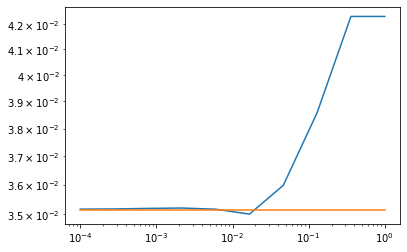

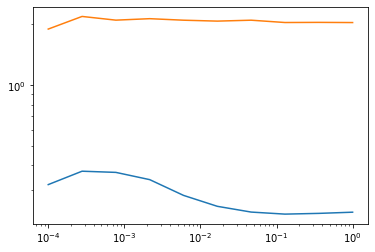

In [10]:
fig, ax = plt.subplots()
ax.loglog(tols, errs[:, :, 0].mean(axis=1))
ax.loglog(tols, errs[:, :, 1].mean(axis=1))

fig, ax = plt.subplots()
ax.loglog(tols, times[:, :, 0].mean(axis=1))
ax.loglog(tols, times[:, :, 1].mean(axis=1))